In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
with open("data/oneline_svg.txt") as f:
    line = f.readline()
#print(line)

In [3]:
import math
pointx = []
pointy = []
scale = 0.1
class P():
    def __init__(self, x=0.0, y=0.0):
        self.x = x
        self.y = y
        
    def __str__(self):
        return str(self.x) + ',' + str(self.y)
p = P()
commands = line.split(' ')
current = None
two_value_cmd = ('M', 'm', 'C', 'c', 'L', 'l')
line_cmd = ('L', 'l')
curve_cmd = ('C', 'c')
move_cmd = ('M', 'm')

drawx = []
drawy = []
c_start = P()
c_end = P()
c1 = P()
c2 = P()
last_p = P()
counter = 0

delta = 1.2
def draw_line(p1, p2):
    xs = []
    ys = []
    dist = math.sqrt((p1.x - p2.x)**2 + (p1.y - p2.y)**2)
    if dist <= delta:
        return [p1.x], [p1.y]
    n = int(dist / delta)
    
    dx = p2.x - p1.x
    dy = p2.y - p1.y
    for i in range(n):
        xs.append(p1.x + float(i) / n * dx)
        ys.append(p1.y + float(i) / n * dy)
    return xs, ys

def bezier_interpolation_at_t(p0, p1, p2, p3, t):
    """Returns the bezier point at the time t."""
    M = np.array([[-1, 3, -3, 1], \
                [3, -6, 3, 0], \
                [-3, 3, 0, 0], \
                [1, 0, 0, 0]])
    G = np.vstack((p0, p1, p2, p3))
    T = np.array([[t*t*t, t*t, t, 1]])
    result = T@M@G
    return result[0] # result is 1*4 2d array

def draw_curve(start, ctrl1, ctrl2, end):
    #print ("draw curve", start, ctrl1, ctrl2, end)
    dist = math.sqrt((start.x - end.x)**2 + (start.y - end.y)**2)
    if dist <= delta:
        return [p1.x], [p1.y]
    xs = []
    ys = []
    n = int(dist / delta)
    
    p0 = np.array([start.x, start.y])
    p1 = np.array([ctrl1.x, ctrl1.y])
    p2 = np.array([ctrl2.x, ctrl2.y])
    p3 = np.array([end.x, end.y])
    for i in range(n):
        t = float(i) / n
        x, y = bezier_interpolation_at_t(p0, p1, p2, p3, t)
        xs.append(x)
        ys.append(y)
    return xs, ys
    

for command in commands:
    if len(command) > 1:
        last_p.x, last_p.y = p.x, p.y
        if current in two_value_cmd:
            x, y = command.split(',')
            x = float(x) * scale
            y = float(y) * scale
            
            if current in line_cmd:
                if current.isupper():
                    p.x, p.y = x, y
                else:
                    p.x += x
                    p.y += y
                xs, ys = draw_line(last_p, p)
                drawx += xs
                drawy += ys
            elif current in curve_cmd:
                if counter == 0:
                    curve_p = c_start
                    counter += 1
                elif counter == 1:
                    curve_p = c1
                    counter += 1
                elif counter == 2:
                    curve_p = c2
                    counter += 1
                elif counter == 3:
                    curve_p = c_end
                    counter += 1
                    
                if current.isupper():
                    curve_p.x = x
                    curve_p.y = y
                else:
                    curve_p.x = last_p.x + x
                    curve_p.y = last_p.y + y
                    
                p.x, p.y = curve_p.x, curve_p.y
                
                if counter == 4:
                    counter = 1
                    xs, ys = draw_curve(c_start, c1, c2, c_end)
                    drawx += xs
                    drawy += ys
                    c_start.x, c_start.y = p.x, p.y
            elif current in move_cmd:
                if current.isupper():
                    p.x = x
                    p.y = y
                else:
                    p.x += x
                    p.y += y
        else:
            value = float(command) * 0.1
            
            if current == 'V':
                p.y = value
            elif current == 'v':
                p.y += value
            elif current == 'H':
                p.x = value
            elif current == 'h':
                p.x += value
            xs, ys = draw_line(last_p, p)
            drawx += xs
            drawy += ys
        if counter < 1:
            pointx.append(p.x)
            pointy.append(p.y)
    elif len(command) == 1:
        current = command
        if current in curve_cmd:
            c_start.x, c_start.y = p.x, p.y
            counter = 1
        #print(current)

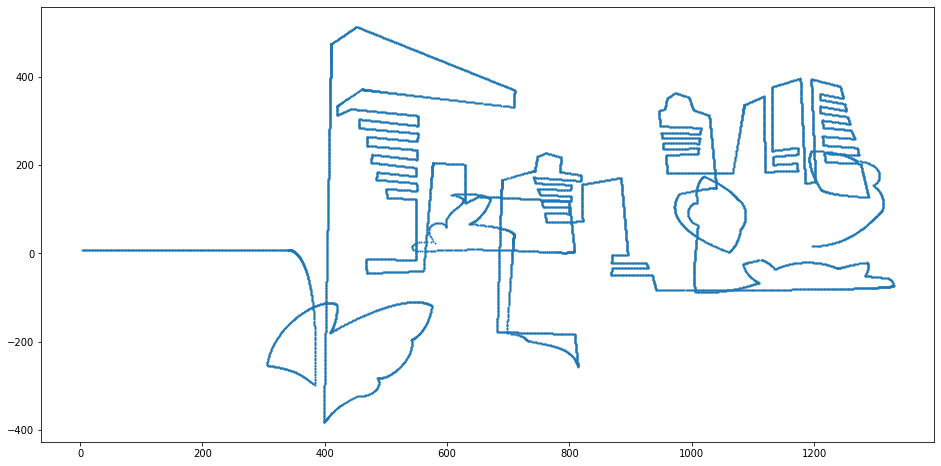

In [4]:
plt.figure(figsize=(16,8))
plt.scatter(drawx, drawy, s=1)

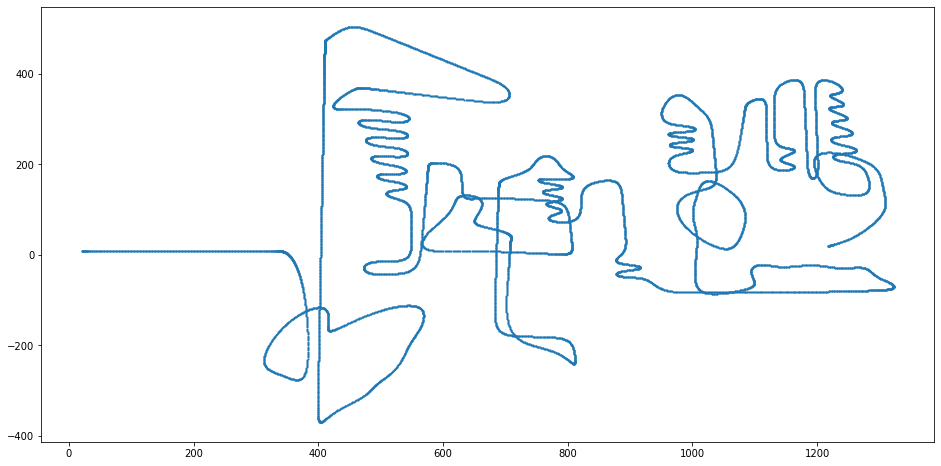

In [5]:
import pandas as pd
def kz(series, window, iterations):
    """KZ filter implementation
    series is a pandas series
    window is the filter window m in the units of the data (m = 2q+1)
    iterations is the number of times the moving average is evaluated
    """
    z = pd.Series(series)
    for i in range(iterations):
        z = z.rolling(window, min_periods=1, center=True).mean()
        #z = pd.rolling_mean(z, window=window, min_periods=1, center=True)
    return z.to_numpy()

window = 40
iters = 2
orig_times = kz(np.array([i for i in range(len(drawx))]), window, iters)
pointx = kz(drawx, window, iters)
pointy = kz(drawy, window, iters)
pointtimes = kz(orig_times, window, iters)
plt.figure(figsize=(16,8))
plt.scatter(pointx, pointy, s=1)

In [6]:
from data_utils import *
from helpers import *
from sketch_transfer import *
from model_1enc import *

In [7]:
def load_model(enc, dec, hp):
    model = SketchTransfer_enc_dec(hp)
    saved_enc = torch.load(enc)
    saved_dec = torch.load(dec)
    model.encoder.load_state_dict(saved_enc)
    model.decoder.load_state_dict(saved_dec)
    return model

hp = HParams()
hp.enc_hidden_size = 256  # 256
hp.dec_hidden_size = 512  # 512
hp.Nmax = 100
hp.style_dim = 7#5
hp.Nz = 2   # latent dimension
hp.Nz_dec = hp.Nz # 1 encoder, 1 decoder
hp.M = 3 # gaussian mixture

#model = load_model("models/0204/sketch_encoder_sel_0.026446_epoch_500.pth",
#                                  "models/0204/sketch_decoder_sel_0.026446_epoch_500.pth", hp)
model = load_model("models/0208/sketch_encoder_sel_0.116334_epoch_1200.pth",
                   "models/0208/sketch_decoder_sel_0.116334_epoch_1200.pth", hp)
model.encoder.train(False)
model.decoder.train(False)

LSTMDecoder(
  (fc_hc): Linear(in_features=9, out_features=1024, bias=True)
  (lstm): LSTM(11, 512)
  (fc_params): Linear(in_features=512, out_features=18, bias=True)
)

sequence length =  5483


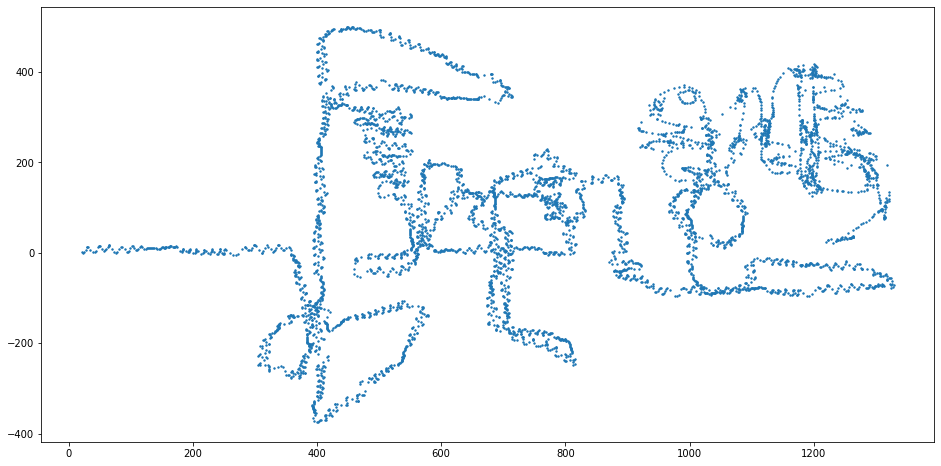

In [19]:
plt.figure(figsize=(16,8))
control, control_times, tangents = normalizeControl(pointx, pointy, pointtimes, 2.0)
stroke_latent = torch.FloatTensor([[-1, -1]]).cuda()
labels = torch.FloatTensor([[0, 0, 0.0, 0.0, 0, 1.0, 0.0]]).cuda()
model.hp.temperature = 0.01
partial = len(control)#2000
print("sequence length = ", partial)
_, __, dx, dy = model.generate_with_latent(stroke_latent, labels, steps=partial)
assert len(dx) == partial
N = len(dx)
bitangents = np.vstack([-tangents[:,1], tangents[:,0]]).T
#control_x = control[:,0]
#control_y = control[:,1]
scale = 1.0
new_points = control[:partial] + np.vstack([dx, dx]).T * tangents[:partial] * scale + np.vstack([dy, dy]).T * bitangents[:partial] * scale
plt.scatter(new_points[:,0], new_points[:,1], s=2)

In [98]:
def load_model(enc, dec, hp):
    model = SketchTransfer_1enc(hp)
    saved_enc = torch.load(enc)
    saved_dec = torch.load(dec)
    model.encoder.load_state_dict(saved_enc)
    model.decoder.load_state_dict(saved_dec)
    return model

hp = HParams()
hp.enc_hidden_size = 128  # 256
hp.dec_hidden_size = 256  # 512
hp.Nmax = 100
hp.save_every = 100
hp.wKL = 0.001
hp.KL_start = 0.01
hp.KL_delta = 0.003
hp.KL_min = 0.0
hp.lr = 0.001
hp.lr_decay = 0.999
hp.style_dim = 5
hp.Nz = 2   # latent dimension
hp.Nz_dec = hp.Nz # 1 encoder, 1 decoder
hp.M = 3 # gaussian mixture

model = load_model("models/0203/sketch_encoder_sel_0.815377_epoch_500.pth",
                                  "models/0203/sketch_decoder_sel_0.815377_epoch_500.pth", hp)
model.encoder.train(False)
model.decoder.train(False)

LSTMDecoder(
  (fc_hc): Linear(in_features=2, out_features=512, bias=True)
  (lstm): LSTM(4, 256)
  (fc_params): Linear(in_features=256, out_features=18, bias=True)
)

sequence length =  5483


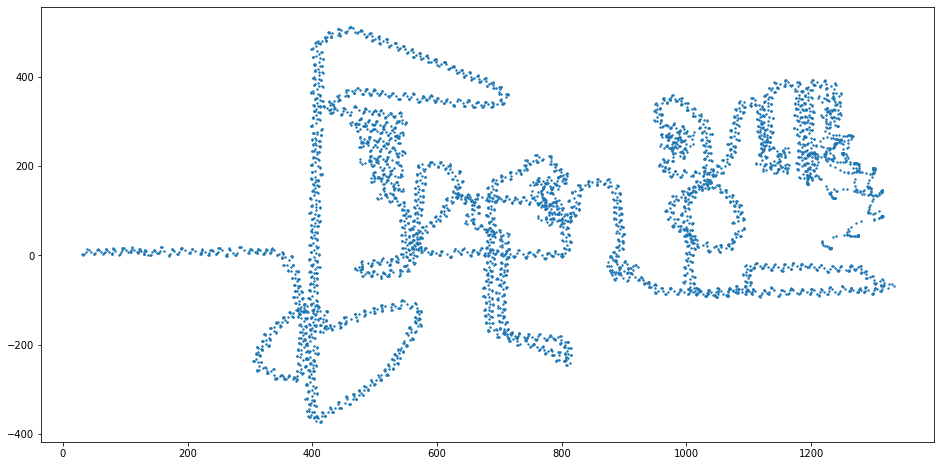

In [100]:
plt.figure(figsize=(16,8))
control, control_times, tangents = normalizeControl(pointx, pointy, pointtimes, 2.0)
stroke_latent = torch.FloatTensor([[-1,-0.5]]).cuda()
model.hp.temperature = 0.5
partial = len(control)#2000
print("sequence length = ", partial)
_, __, dx, dy = model.generate_with_latent(stroke_latent, steps=partial)
assert len(dx) == partial
N = len(dx)
bitangents = np.vstack([-tangents[:,1], tangents[:,0]]).T
#control_x = control[:,0]
#control_y = control[:,1]
scale = 1.0
new_points = control[:partial] + np.vstack([dx, dx]).T * tangents[:partial] * scale + np.vstack([dy, dy]).T * bitangents[:partial] * scale
plt.scatter(new_points[:,0], new_points[:,1], s=2)

tensor([[ 3.9048,  5.3104, -2.6344, -4.4496]], device='cuda:0',
       grad_fn=<AddBackward0>)


D:\Dropbox (GaTech)\Dropbox (GaTech)\Research\MS Project\Draw_AI\sketch_transfer.py:99: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,self.hp.M)


tensor([[ 4.0649,  4.4549, -1.9371, -4.6541]], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor([[ 4.2496,  3.3152, -3.7603, -4.8524]], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor([[ 3.2560,  4.8175, -4.9805, -3.8020]], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor([[ 3.5949,  4.3651, -2.5728, -4.6973]], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor([[ 4.3240,  4.2281, -3.1293, -4.2571]], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor([[ 4.5774,  4.0181, -3.0388, -4.6564]], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor([[ 4.3354,  4.2511, -3.0911, -4.3590]], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor([[ 4.0877,  4.4011, -3.2229, -4.4803]], device='cuda:0',
       grad_fn=<AddBackward0>)


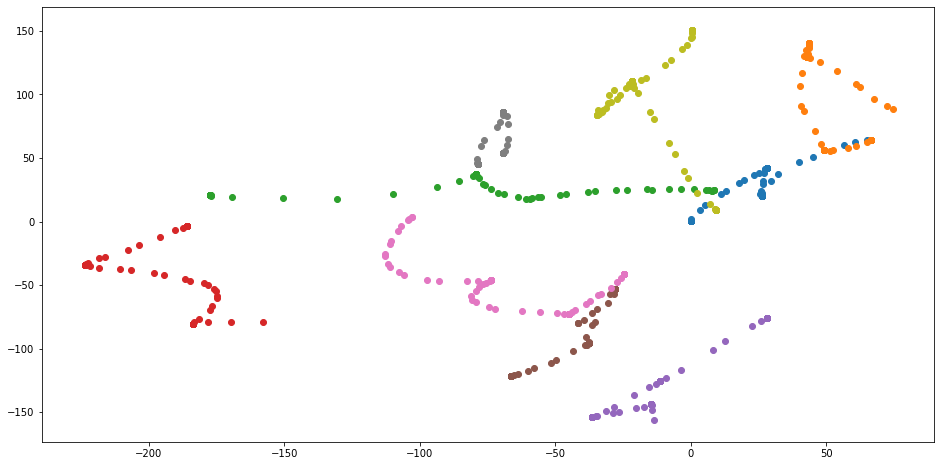

In [9]:
control_dx = (pointx[1:] - pointx[:-1]) * 1.0
control_dy = (pointy[1:] - pointy[:-1]) * 1.0
x = 1000
control_dx = control_dx[:x]
control_dy = control_dy[:x]
i = 0
length = 100
x = 0.0
y = 0.0
plt.figure(figsize=(16,8))
while i + length < len(control_dx):
    control = torch.FloatTensor(np.vstack((control_dx[i:i+length], control_dy[i:i+length]))).cuda().unsqueeze(0).permute(2, 0, 1)
    latent = torch.FloatTensor([1, 0, 3.5, -8]).cuda().unsqueeze(0)
    xs, ys, dx, dy = model.generate_with_control(control, latent)
    #plt.scatter(xs + x, ys + y, s=1)
    plt.scatter(xs + x, ys + y)
    x = xs[-1]
    y = ys[-1]
    i += length

Encoded style:  [0. 1. 0. 0. 0.]


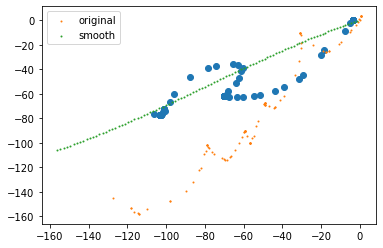

In [62]:
model.hp.temperature = 0.3
idx = 4080
data, style = dataset[idx]
control = torch.FloatTensor(data).cuda().unsqueeze(0).permute(2, 0, 1)[:, :, 2:]
latent = torch.FloatTensor([-2, 0, 7, -5]).cuda().unsqueeze(0)
xs, ys, dx, dy = model.generate_with_control(control, latent)
plt.scatter(xs, ys)
dataset.visualize(idx)

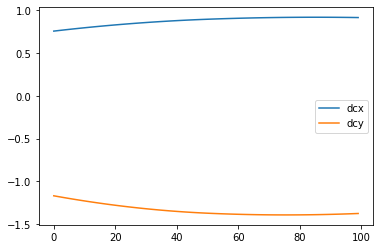

In [29]:
data, style = dataset[100]
plt.plot(data[2, :], label="dcx")
plt.plot(data[3, :], label="dcy")
plt.legend()

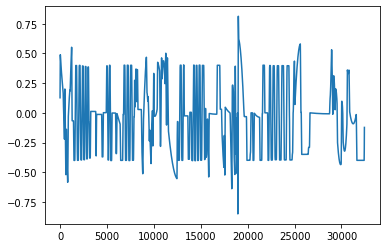

In [31]:
plt.plot(control_dx)